In [1]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train = pd.read_csv("train.csv")

In [3]:
Y = train["label"]
X = train.drop(labels = ["label"],axis = 1)

In [4]:
x = X.values.reshape(42000, 28, 28, 1)

In [5]:
x = x.astype('float32')
x /= 255

In [6]:
num_classes = 10
y = keras.utils.to_categorical(Y, num_classes)
print(y[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.1, random_state=5)
print('Qtde de treino: {}'.format(len(x_train)))
print('Qtde de validação: {}'.format(len(x_val)))

Qtde de treino: 37800
Qtde de validação: 4200


In [8]:
model = Sequential()
model.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 20)        200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 40)        7240      
_________________________________________________________________
flatten (Flatten)            (None, 4840)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                242050    
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [10]:
batch_size = 32
epochs = 20

In [11]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    verbose=1,
                    validation_data=(x_val, y_val))

Epoch 1/20
1182/1182 [==============================] - 28s 23ms/step - loss: 0.4216 - accuracy: 0.8663 - val_loss: 0.0742 - val_accuracy: 0.9774

Epoch 00001: val_loss improved from inf to 0.07421, saving model to model.h5
Epoch 2/20
1182/1182 [==============================] - 27s 23ms/step - loss: 0.0857 - accuracy: 0.9754 - val_loss: 0.0553 - val_accuracy: 0.9833

Epoch 00002: val_loss improved from 0.07421 to 0.05531, saving model to model.h5
Epoch 3/20
1182/1182 [==============================] - 27s 23ms/step - loss: 0.0540 - accuracy: 0.9848 - val_loss: 0.0474 - val_accuracy: 0.9871

Epoch 00003: val_loss improved from 0.05531 to 0.04738, saving model to model.h5
Epoch 4/20
1182/1182 [==============================] - 27s 23ms/step - loss: 0.0449 - accuracy: 0.9871 - val_loss: 0.0562 - val_accuracy: 0.9836

Epoch 00004: val_loss did not improve from 0.04738
Epoch 5/20
1182/1182 [==============================] - 27s 23ms/step - loss: 0.0352 - accuracy: 0.9887 - val_loss: 0.0542

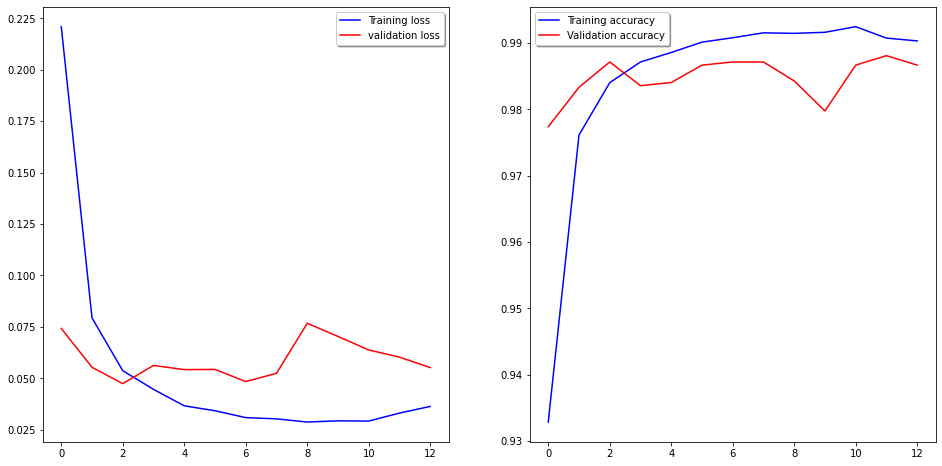

In [12]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [13]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

In [14]:
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04737789183855057
Test accuracy: 0.9871428608894348


In [15]:
print(y_train[10])
print(model.predict(x_train[10].reshape((1,28,28,1))))
print(model.predict_classes(x_train[10].reshape((1,28,28,1))))

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[[1.2424860e-04 2.8368257e-05 1.1144112e-05 1.9641875e-05 7.5108325e-01
  8.0129023e-05 2.3742092e-01 2.9046796e-04 9.9153342e-03 1.0264851e-03]]
[4]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [16]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       417
           1       1.00      1.00      1.00       480
           2       0.99      0.99      0.99       408
           3       1.00      0.97      0.98       437
           4       0.99      0.99      0.99       391
           5       0.98      0.98      0.98       377
           6       0.98      1.00      0.99       413
           7       0.99      0.99      0.99       450
           8       0.98      0.99      0.98       381
           9       0.98      0.98      0.98       446

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



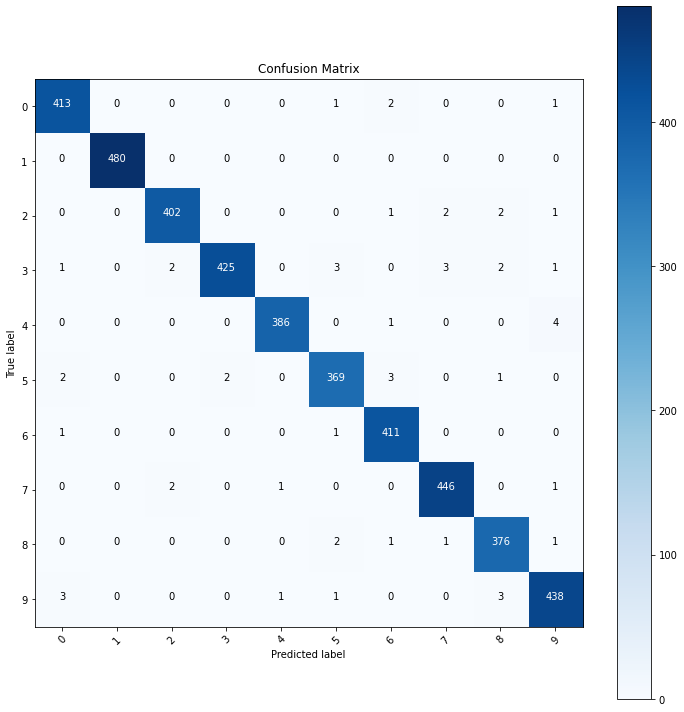

In [17]:
import numpy as np

# Classificando toda base de teste
y_pred = model.predict_classes(x_val)
# voltando pro formato de classes
y_test_c = np.argmax(y_val, axis=1)
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

#Confution Matrix
cm = confusion_matrix(y_test_c, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, y_pred, target_names=target_names))